# PyTorch Model Deployment

we will be deploying the same model that we trained in the previous notebook i.e. [pizza-steak-sushi classification]. <br>

Criteria to meet: <br>
* The model should work on a mobile device.
* The model should make predictions fast.
* Where is it going to go?
    - On-device?
    - On the cloud?
* How will it be used?
    - Real-time?
    - offline [Batch processing]?
    


# 0. Getting Setup

In [1]:
import os 
import sys
sys.path.append('../2.Going_Modular/') 

In [2]:
from pathlib import Path
import zipfile
import requests
from going_modular import data_setup, engine, utils #type: ignore

import torch
from torch import nn
import torchvision
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torchinfo import summary

import matplotlib.pyplot as plt

c:\Users\sachi\anaconda3\envs\DeepLearning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### HYPERPARAMETERS:

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 16
NUM_WORKERS = 4
device

'cuda'

In [4]:
from typing import List

def set_seeds(seed:int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


def plot_loss_curves(results):
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()



def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    """Makes a prediction on a target image with a trained model and plots the image.

    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str], optional): different class names for target image. Defaults to None.
        transform (_type_, optional): transform of target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".
    
    Returns:
        Matplotlib plot of target image and model prediction as title.

    Example usage:
        pred_and_plot_image(model=model,
                            image="some_image.jpeg",
                            class_names=["class_1", "class_2", "class_3"],
                            transform=torchvision.transforms.ToTensor(),
                            device=device)
    """

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

# 1. Get the data

In [5]:
# this time we will be using same dataset but the one with more samples 
import requests

data = Path('data')
image_path = data/"pizza_steak_sushi_20_percent"

if image_path.exists():
    print(f"{image_path} directory already exists . . ")
else:
    image_path.mkdir(parents=True, exist_ok=True)
    
    with open(data/"pizza_steak_sushi_20_percent.zip",'wb') as f:
        print(" Downloading the dataset . . . .")
        response = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        f.write(response.content)
        print(" Suceccfully donwnloaded the dataset ")
        
    with zipfile.ZipFile(data/"pizza_steak_sushi_20_percent.zip",'r') as z:
        z.extractall(image_path)
        
    os.remove(data/"pizza_steak_sushi_20_percent.zip")
    
    

data\pizza_steak_sushi_20_percent directory already exists . . 


In [6]:
train_dir = image_path/"train"
test_dir =image_path/"test"

# 2. EffNet or ViT?

Different models have different trade-offs. The EfficientNet models are smaller and faster to run than the Vision Transformer models but the Vision Transformer models have been shown to perform well on a variety of tasks. <br>
The selection of the model in this case will depend on the: <br>
* Accuracy
* Speed

## 2.1 Analyzing EffNetB2

In [7]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT 

effnetb2_transforms = effnetb2_weights.transforms()

effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights).to(device)

for param in effnetb2.parameters():
    param.requires_grad = False
    

In [7]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [8]:
# 5. Update the classifier head
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), # keep dropout layer same
    nn.Linear(in_features=1408, # keep in_features same 
              out_features=3)) # change out_features to suit our number of classes

### Creating a function to do all these

In [9]:
def create_effnetb2_model(num_classes : int=3,
                          seed:int=42):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)
    
    for param in model.parameters():
        param.requires_grad = False
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features= num_classes)
    ).to(device)
    return model, transforms

In [10]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

### Make dataloader for efnetb2

In [11]:
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=16)

### Train EffNetB2 

In [12]:
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

 10%|█         | 1/10 [00:17<02:39, 17.77s/it]

Epoch: 1 | train_loss: 0.9235 | train_acc: 0.5991 | test_loss: 0.6560 | test_acc: 0.9083


 20%|██        | 2/10 [00:31<02:04, 15.57s/it]

Epoch: 2 | train_loss: 0.6057 | train_acc: 0.8470 | test_loss: 0.4967 | test_acc: 0.9313


 30%|███       | 3/10 [00:46<01:44, 14.99s/it]

Epoch: 3 | train_loss: 0.5092 | train_acc: 0.8642 | test_loss: 0.4006 | test_acc: 0.9437


 40%|████      | 4/10 [01:00<01:27, 14.63s/it]

Epoch: 4 | train_loss: 0.3798 | train_acc: 0.8987 | test_loss: 0.3751 | test_acc: 0.9563


 50%|█████     | 5/10 [01:14<01:12, 14.42s/it]

Epoch: 5 | train_loss: 0.3630 | train_acc: 0.9030 | test_loss: 0.3207 | test_acc: 0.9688


 60%|██████    | 6/10 [01:28<00:56, 14.24s/it]

Epoch: 6 | train_loss: 0.3682 | train_acc: 0.8944 | test_loss: 0.3075 | test_acc: 0.9521


 70%|███████   | 7/10 [01:42<00:42, 14.19s/it]

Epoch: 7 | train_loss: 0.3218 | train_acc: 0.9095 | test_loss: 0.2860 | test_acc: 0.9625


 80%|████████  | 8/10 [01:56<00:28, 14.21s/it]

Epoch: 8 | train_loss: 0.3325 | train_acc: 0.8901 | test_loss: 0.2649 | test_acc: 0.9625


 90%|█████████ | 9/10 [02:10<00:14, 14.19s/it]

Epoch: 9 | train_loss: 0.3039 | train_acc: 0.9009 | test_loss: 0.2626 | test_acc: 0.9625


100%|██████████| 10/10 [02:24<00:00, 14.45s/it]

Epoch: 10 | train_loss: 0.3162 | train_acc: 0.8772 | test_loss: 0.2484 | test_acc: 0.9688


In [21]:
device 

'cpu'

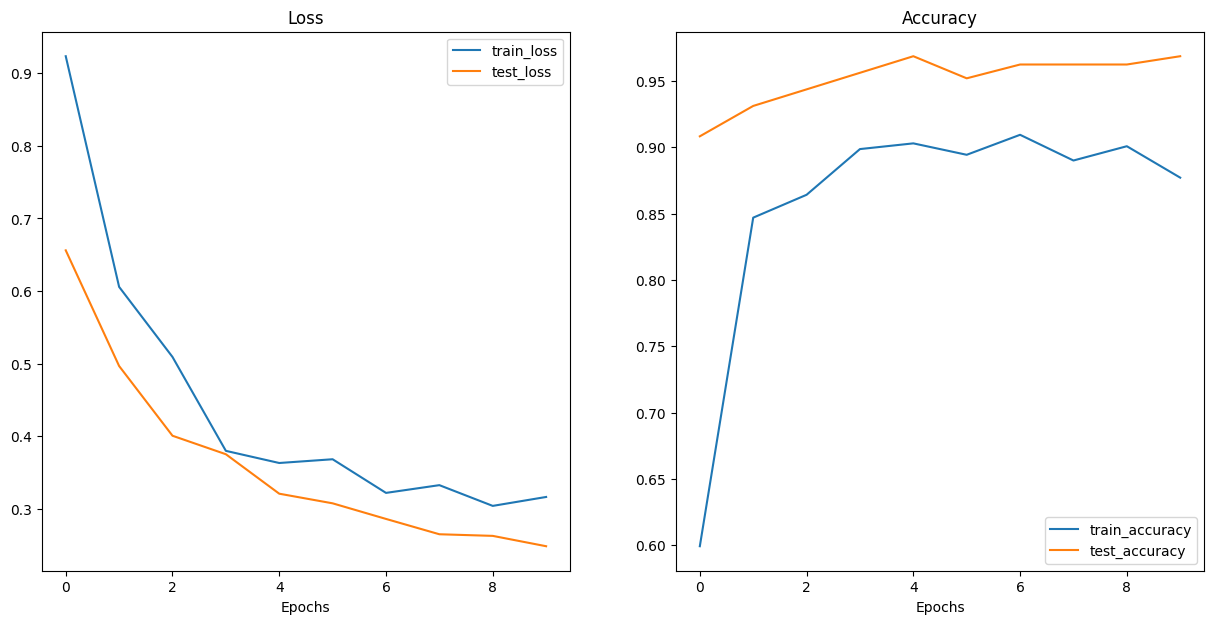

In [13]:
plot_loss_curves(effnetb2_results)

In [31]:
target = Path("Models")
name = "Pretrained_effnet_v2_20_percent.pth"

utils.save_model(model= effnetb2,
           target_dir =  target,
           model_name = name)

[INFO] Saving model to: Models\Pretrained_effnet_v2_20_percent.pth


### checking the size of EffNetB2 model

In [15]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path(r"Models\Pretrained_effnet_v2_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


In [17]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": sum(torch.numel(param) for param in effnetb2.parameters()),
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.24836863055825234,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

## 2.1 ViT model

In [34]:
def create_vit_model(num_classes:int=3, 
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model. 
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights).to(device)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)).to(device) # update to reflect target number of classes
    
    return model, transforms


In [35]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

### Create Dataloader for ViT

In [36]:
# Setup ViT DataLoaders
from going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

### Training the Vit    

In [37]:
from going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

 10%|█         | 1/10 [00:28<04:15, 28.41s/it]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381


 20%|██        | 2/10 [00:56<03:43, 27.97s/it]

Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602


 30%|███       | 3/10 [01:25<03:19, 28.50s/it]

Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693


 40%|████      | 4/10 [01:52<02:48, 28.15s/it]

Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722


 50%|█████     | 5/10 [02:20<02:19, 27.87s/it]

Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784


 60%|██████    | 6/10 [02:48<01:52, 28.11s/it]

Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722


 70%|███████   | 7/10 [03:16<01:24, 28.05s/it]

Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784


 80%|████████  | 8/10 [03:43<00:55, 27.66s/it]

Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722


 90%|█████████ | 9/10 [04:09<00:27, 27.28s/it]

Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784


100%|██████████| 10/10 [04:36<00:00, 27.65s/it]

Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


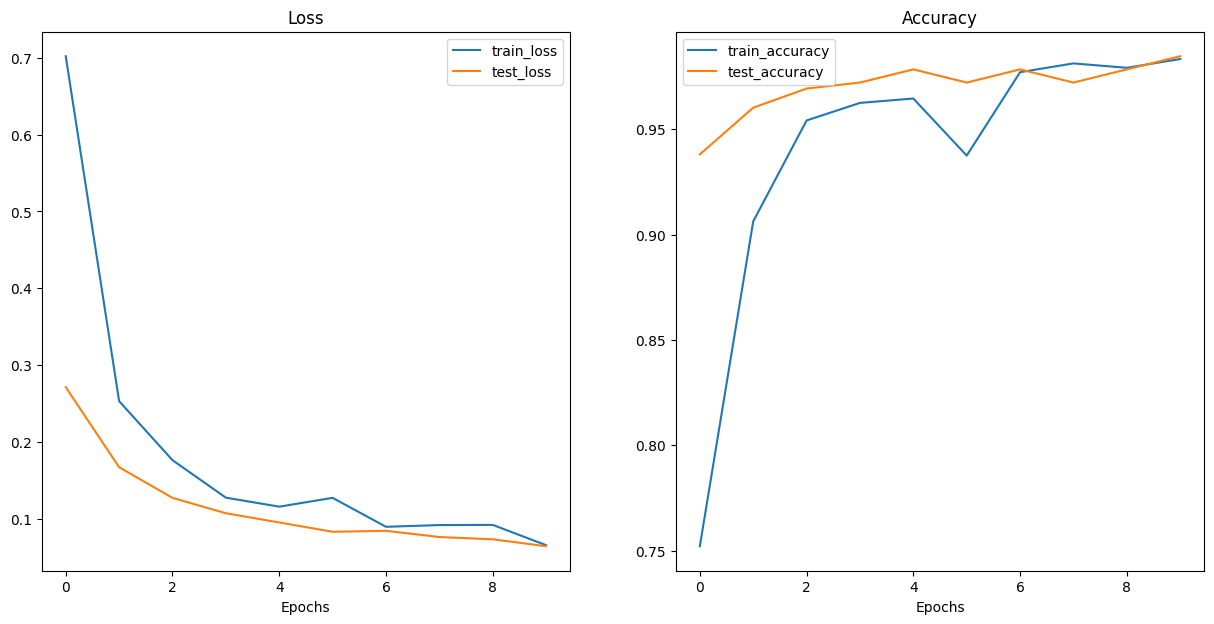

In [38]:
plot_loss_curves(vit_results)

In [39]:
# Save the model
target = Path("Models")
name = "Pretrained_vit_20_percent.pth"

utils.save_model(model=vit,
                 target_dir=target,
                 model_name=name)

[INFO] Saving model to: Models\Pretrained_vit_20_percent.pth


### Checking size fo ViT

In [40]:
pretrained_vit_model_size = Path(r"Models\Pretrained_vit_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In [42]:
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": sum(torch.numel(param) for param in vit.parameters()),
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06443448299542069,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

# 3. Making Prediction with model

### Predicting with EffNetB2

In [43]:
# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data\pizza_steak_sushi_20_percent\test


[WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg')]

In [44]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer 
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path], 
                   model: torch.nn.Module,
                   transform: torchvision.transforms, 
                   class_names: List[str], 
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    
    # 2. Create an empty list to store prediction dictionaries
    pred_list = []
    
    # 3. Loop through target paths
    for path in tqdm(paths):
        
        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
        
        # 6. Start the prediction timer
        start_time = timer()
        
        # 7. Open image path
        img = Image.open(path)
        
        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device) 
        
        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()
        
        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample 
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on) 
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            
            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)
    
    # 15. Return list of prediction dictionaries
    return pred_list

In [45]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU 

100%|██████████| 150/150 [00:10<00:00, 13.68it/s]


In [46]:
# Inspect the first 2 prediction dictionaries
effnetb2_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9982,
  'pred_class': 'pizza',
  'time_for_pred': 0.1985,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.5452,
  'pred_class': 'pizza',
  'time_for_pred': 0.0712,
  'correct': True}]

In [48]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9982,pizza,0.1985,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.5452,pizza,0.0712,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9971,pizza,0.0647,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.7465,pizza,0.1055,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.8351,pizza,0.0667,True


In [49]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

correct
True     145
False      5
Name: count, dtype: int64

In [50]:
# Find the average time per prediction 
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.0727 seconds


In [51]:
# Add EffNetB2 average prediction time to stats dictionary 
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.24836863055825234,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': np.float64(0.0727)}